In [8]:
import numpy as np
import pandas as pd
import pickle


# load in the brain data
with open('../spoof_data/new_brains.pickle', 'rb') as f:
    brains = pickle.load(f)

In [73]:
from monai.transforms import (
    Compose,
    EnsureChannelFirst,
    ScaleIntensity,
    CropForeground,
    SpatialPad,
    ToTensor
)

transform = Compose([
    EnsureChannelFirst(channel_dim="no_channel"),  # Change from None to "no_channel" for 3D data
    ScaleIntensity(),
    CropForeground(select_fn=lambda x: x > 0.1),
    SpatialPad(spatial_size=(70, 70, 70)),
    ToTensor()
])

In [74]:
# Let's also add some error checking
cropped_brains = []
for i, brain in enumerate(brains):
    try:
        print(f"Processing brain {i}, shape: {brain.shape}")  # Debug info
        cropped_brain = transform(brain)
        cropped_brains.append(cropped_brain)
        break
    except Exception as e:
        print(f"Error processing brain {i}: {e}")
        print(f"Brain shape: {brain.shape}, dtype: {brain.dtype}")
        break

Processing brain 0, shape: (91, 109, 91)


In [75]:
cropped_brains = np.array(cropped_brains)

In [76]:
# check the percent of the brain that is zero
# do it for the first brain
np.sum(cropped_brains[0] == 0) / cropped_brains[0].size

0.9663965014577259

In [83]:
cropped_brains[0].max()

1.0

In [77]:
cropped_brains.shape

(1, 1, 70, 70, 70)

In [78]:
# Debug step by step
brain = brains[0]
brain_channel = EnsureChannelFirst(channel_dim="no_channel")(brain)
brain_scaled = ScaleIntensity()(brain_channel)

# Try getting the result directly first
result = CropForeground(
    select_fn=lambda x: x > 0,
    margin=0,
    return_coords=True
)(brain_scaled)

# Print what we get back
print("Type of result:", type(result))
print("Result structure:", result)

Type of result: <class 'tuple'>
Result structure: (metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.

In [79]:
# Try with a higher threshold and check coordinates
result = CropForeground(
    select_fn=lambda x: x > 0.2,  # Further increased threshold
    margin=0,  # No margin to see the raw crop
    return_coords=True
)(brain_scaled)

cropped_data, start_coord, end_coord = result
print("Start coordinates:", start_coord)
print("End coordinates:", end_coord)
print("Cropped shape:", cropped_data.shape)

# Check the value distribution
unique_vals = np.unique(brain_scaled.numpy())
print("Min non-zero value:", np.min(unique_vals[unique_vals > 0]))
print("Max value:", np.max(unique_vals))

Start coordinates: [11 16 31]
End coordinates: [80 71 77]
Cropped shape: torch.Size([1, 69, 55, 46])
Min non-zero value: 0.032741193
Max value: 1.0


In [85]:
import scipy.io

# load data.mat 
data = scipy.io.loadmat('data.mat')

brains[0] = data['new_brain']

print(brains[0].shape)
print(brains[0].max())

(91, 109, 91)
3473.316112788602


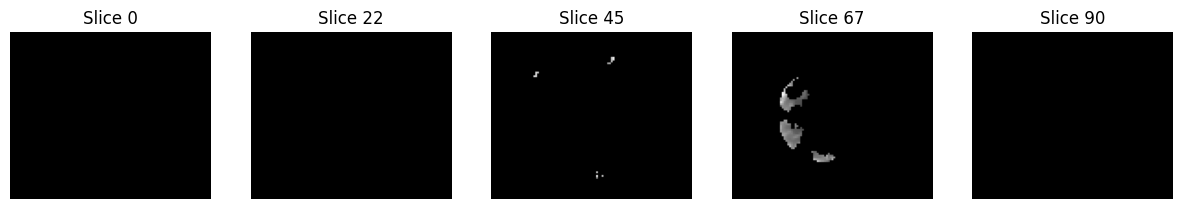

In [81]:
import matplotlib.pyplot as plt

# Function to visualize slices
def visualize_slices(data, num_slices=5):
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 3))
    slice_indices = np.linspace(0, data.shape[2] - 1, num_slices, dtype=int)
    
    for i, ax in enumerate(axes):
        ax.imshow(data[:, :, slice_indices[i]], cmap='gray')
        ax.set_title(f'Slice {slice_indices[i]}')
        ax.axis('off')
    
    plt.show()

# Visualize slices of the first brain
brain = brains[0]
visualize_slices(brain)